In [30]:
import pandas as pd
pd.options.plotting.backend = "plotly"

# Train data

In [27]:
train = pd.read_csv(r'C:\Users\Admin\Code\LSTMforecast\data\bayfield_jail-courthouse_load_persist_210829_240608_1min_IMFs.csv',
                    #'~/OneDrive/Data/Load/Commercial/bayfield_jail-courthouse_load_persist_210829_240608_1min.csv',
                    index_col=0, parse_dates=True, comment='#').resample('60min').mean()
train = train.iloc[:24*int(0.95*len(train)//24)]
train = train.rename(columns={'Load [kW]':'true','Persist [kW]':'pers'})
#train.columns = ['true','pers']
train

,true,pers,Diff1Wkday [kW],IMF1,IMF2,IMF3,IMF4,IMF5,IMF6,IMF7,IMF8,IMF9,IMF10,IMF11,IMF12
Datetime CST,,,,,,,,,,,,,,,
2021-08-30 00:00:00,59.835304,59.678520,-0.156784,1.743201,1.560411,8.616990,-90.027894,37.099427,0.256739,-2.856360,2.149030,8.660044,6.355211,-1.358011,87.636515
2021-08-30 01:00:00,58.669148,58.046184,-0.622964,-0.890449,7.321704,-1.357597,-87.143777,39.944919,0.113814,-2.765634,2.138501,8.667772,6.361158,-1.357642,87.636381
2021-08-30 02:00:00,61.085111,59.708482,-1.376629,1.044288,-0.166083,-4.028074,-78.798540,42.278101,-0.022372,-2.671734,2.127965,8.675503,6.367083,-1.357273,87.636247
2021-08-30 03:00:00,78.640174,62.709389,-15.930785,0.669384,-2.005460,0.707562,-65.493015,44.035155,-0.151464,-2.574845,2.117423,8.683237,6.372987,-1.356902,87.636113
2021-08-30 04:00:00,103.449429,104.062871,0.613443,-0.628712,2.307851,4.597556,-48.687431,45.152261,-0.273109,-2.475156,2.106876,8.690974,6.378869,-1.356530,87.635979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-17 19:00:00,82.003698,71.086875,-10.916823,0.151146,6.566562,3.032061,-19.125102,0.407534,2.831757,3.376564,1.421519,-7.233509,4.354958,-3.072513,89.292722
2024-04-17 20:00:00,78.309506,73.728267,-4.581239,-0.326733,2.237518,6.085112,-20.680829,0.114870,2.778643,3.340403,1.415703,-7.229473,4.353952,-3.072559,89.292899
2024-04-17 21:00:00,73.084148,71.131879,-1.952269,0.120245,-1.626565,5.503617,-21.502614,-0.192232,2.720640,3.303148,1.409876,-7.225384,4.352944,-3.072603,89.293075


# Persist Errors

In [28]:
train['e_pers'] = train.pers.ffill().bfill() - train.true.ffill().bfill()

print(pd.DataFrame(train.e_pers.values.reshape(-1,24).mean(axis=0)))

pd.DataFrame(train.e_pers.values.reshape(-1,24)).plot(kind='box')

           0
0   0.226452
1   0.224964
2   0.228626
3   0.231559
4   0.273751
5   0.281159
6   0.261728
7   0.262612
8   0.259600
9   0.259131
10  0.261565
11  0.263036
12  0.255293
13  0.249176
14  0.254936
15  0.237588
16  0.236127
17  0.243609
18  0.239629
19  0.212395
20  0.217020
21  0.220621
22  0.220656
23  0.227096


# Forecasts

In [29]:
#filepath = '/home/mjw/Code/LSTMforecast/results/bayfield_jail-courthouse/'
#filepath = '/home/mjw/Code/LSTMforecast/results/bayfield_jail-courthouse_v1.2/'
#filepath = '/home/mjw/Code/LSTMforecast/moresultsdels/bayfield_jail-courthouse_random-search/'
#filepath = '/home/mjw/Code/LSTMforecast/results/bayfield_jail-courthouse_random-search/'
#filepath = '../models/bayfield_jail-courthouse_i96_o96_imf4569_rmWKEND_u128-128_d0.1-0.1/'
filepath = r'C:\Users\Admin\Code\LSTMforecast\results\bayfield_jail-courthouse_v1.3_rand\u48-48_d0_in48_flen6'
df = pd.read_csv(filepath+r'\all_forecasts.csv',index_col=0)

df['timestamp_update'] = pd.to_datetime(df['timestamp_update'])
df['timestamp'] = pd.to_datetime(df['timestamp'])

df['weekday'] = df['timestamp_update'].dt.dayofweek

first_monday = df.loc[df['weekday'] == 0,'timestamp_update'].iloc[0]

df = df.loc[df['timestamp_update'].values >= first_monday,:]

df

,Pred,Load,Persist,timestamp_update,timestamp,weekday
4608,59.765247,59.368459,62.827204,2024-04-22 00:00:00,2024-04-22 00:00:00,0
4609,59.772230,60.558653,60.171424,2024-04-22 00:00:00,2024-04-22 00:15:00,0
4610,60.003006,59.204911,62.853531,2024-04-22 00:00:00,2024-04-22 00:30:00,0
4611,60.247032,59.694957,58.840286,2024-04-22 00:00:00,2024-04-22 00:45:00,0
4612,60.950430,58.747861,62.632080,2024-04-22 00:00:00,2024-04-22 01:00:00,0
...,...,...,...,...,...,...
80635,69.958040,78.573146,74.623892,2024-06-05 23:00:00,2024-06-06 21:45:00,2
80636,70.222206,75.299217,74.636369,2024-06-05 23:00:00,2024-06-06 22:00:00,2
80637,70.777870,77.633942,72.685377,2024-06-05 23:00:00,2024-06-06 22:15:00,2
80638,70.963030,73.523607,76.456359,2024-06-05 23:00:00,2024-06-06 22:30:00,2


# Daily update weekly plots (w/ offset)

In [31]:
pd.options.plotting.backend = 'matplotlib'

## Grid search

In [56]:
#h_offset = 12
wk = 0
pesist_first_x_samples = False



for h1 in range(0,24):
    for h2 in range(0,24):
        if h2>(h1+4):
            skills,daily_skills = [],[]
            h_persist_replace = list(range(h1)) + list(range(h2,24))
            for h_offset in [0]:#[0,4,8,12,16]:
                for wk in range(7):

                    t0 = df['timestamp_update'].iloc[0] + pd.Timedelta(f'{h_offset}h') + wk*pd.Timedelta(f'7d')

                    yweek = pd.DataFrame([])

                    for t in pd.date_range(t0,periods=5,freq='1d'):
                        y = pd.DataFrame({'Meas':df[df.timestamp_update==t]['Load'].iloc[:(5*96)].values,
                                        'LSTM':df[df.timestamp_update==t]['Pred'].iloc[:(5*96)].values,
                                        'Persist':df[df.timestamp_update==t]['Persist'].iloc[:(5*96)].values},
                                            index=df[df.timestamp_update==t]['timestamp'].iloc[:(5*96)])


                        if pesist_first_x_samples:
                            y.iloc[:8,1] = pd.NA #y.iloc[:8,2].values

                        #y.LSTM = y.LSTM * (y.Persist.mean() / y.LSTM.mean()) # scale by mean of persistence

                        #h_persist = 3
                        #y.loc[t:t+pd.Timedelta(hours=h_persist),'LSTM'] = y.loc[t:t+pd.Timedelta(hours=h_persist),'Persist'].values # fill in first few values of persistence

                        #h_persist_replace = list(range(11)) + list(range(21,24))
                        y.loc[y.index.hour.isin(h_persist_replace),'LSTM'] = y.loc[y.index.hour.isin(h_persist_replace),'Persist'].values

                        #new_dfplot = pd.DataFrame({ 'True':y_true.values,'LSTM':y_lstm.values,'Persist':y_pers.values},index=idx)
                        yweek = pd.concat((yweek,y),axis=0)

                        skill_mae = 1 - (y.Meas - y.LSTM).abs().mean() / (y.Meas - y.Persist).abs().mean()
                        skill_mse = 1 - (y.Meas - y.LSTM).pow(2).mean() / (y.Meas - y.Persist).pow(2).mean()
                        daily_skills.append(skill_mae)
                        

                    skill_mae = 1 - (yweek.Meas - yweek.LSTM).abs().mean() / (yweek.Meas - yweek.Persist).abs().mean()
                    skill_mse = 1 - (yweek.Meas - yweek.LSTM).pow(2).mean() / (yweek.Meas - yweek.Persist).pow(2).mean()
                    
                    skills.append(skill_mae)

                    yweek = yweek.interpolate()

                    #yweek.plot(title=f'Skill: {100*skill_mae:.0f}%, Week: {wk}, Offset: {h_offset} h',figsize=(12,6),linewidth=0.5)

            skills = pd.Series(daily_skills)
            print(f"H1 {h1}, H2 {h2}, Mean daily skill: {100*skills.mean():.0f}%, Daily Skills >0: {100*skills[skills.values>0].count()/len(skills):.0f}%")


H1 0, H2 5, Mean daily skill: -2%, Daily Skills >0: 40%
H1 0, H2 6, Mean daily skill: -5%, Daily Skills >0: 26%
H1 0, H2 7, Mean daily skill: -6%, Daily Skills >0: 29%
H1 0, H2 8, Mean daily skill: -4%, Daily Skills >0: 34%
H1 0, H2 9, Mean daily skill: -2%, Daily Skills >0: 46%
H1 0, H2 10, Mean daily skill: -0%, Daily Skills >0: 49%
H1 0, H2 11, Mean daily skill: 1%, Daily Skills >0: 54%
H1 0, H2 12, Mean daily skill: 2%, Daily Skills >0: 54%
H1 0, H2 13, Mean daily skill: 2%, Daily Skills >0: 51%
H1 0, H2 14, Mean daily skill: 1%, Daily Skills >0: 54%
H1 0, H2 15, Mean daily skill: 0%, Daily Skills >0: 54%
H1 0, H2 16, Mean daily skill: -0%, Daily Skills >0: 51%
H1 0, H2 17, Mean daily skill: 0%, Daily Skills >0: 54%
H1 0, H2 18, Mean daily skill: 1%, Daily Skills >0: 51%
H1 0, H2 19, Mean daily skill: 1%, Daily Skills >0: 51%
H1 0, H2 20, Mean daily skill: 1%, Daily Skills >0: 49%
H1 0, H2 21, Mean daily skill: 1%, Daily Skills >0: 51%
H1 0, H2 22, Mean daily skill: -2%, Daily Skil

## Fixed offset = 0

Mean daily skill: 7%
Daily skills > 0: 77%


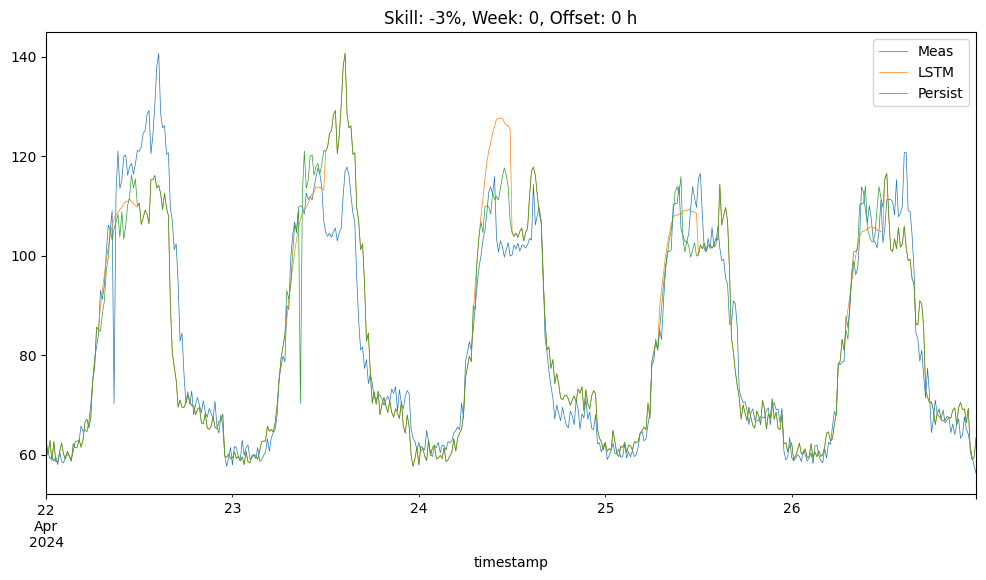

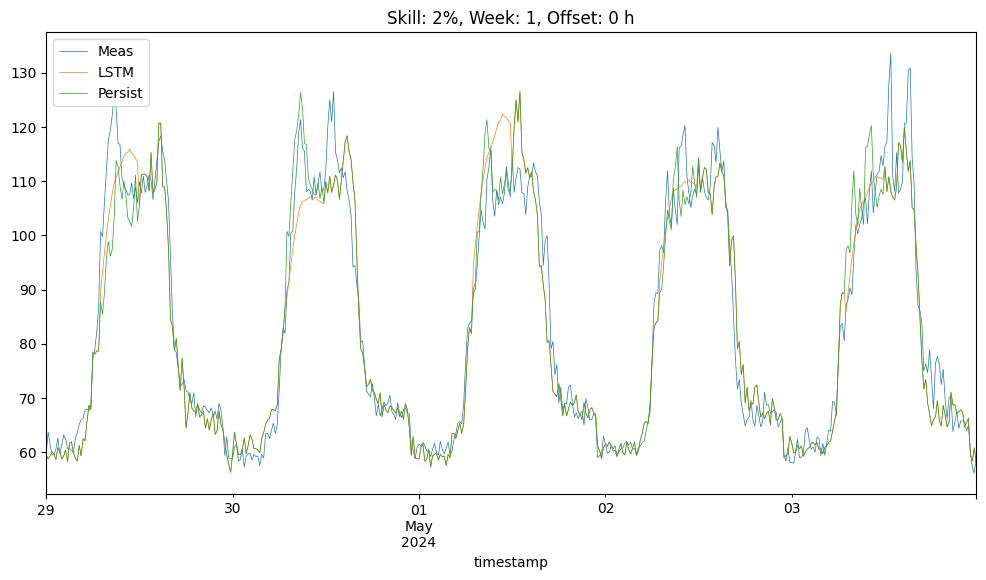

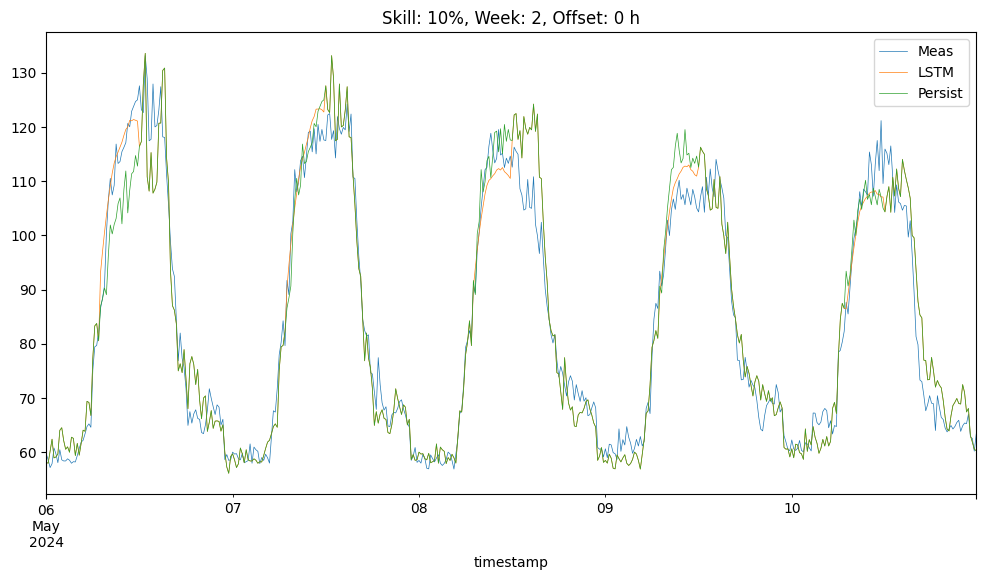

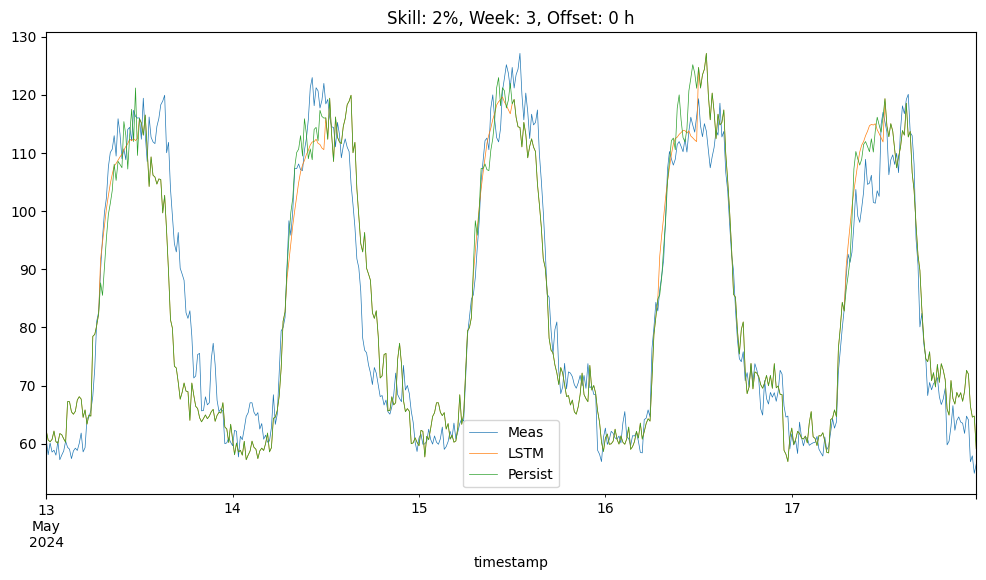

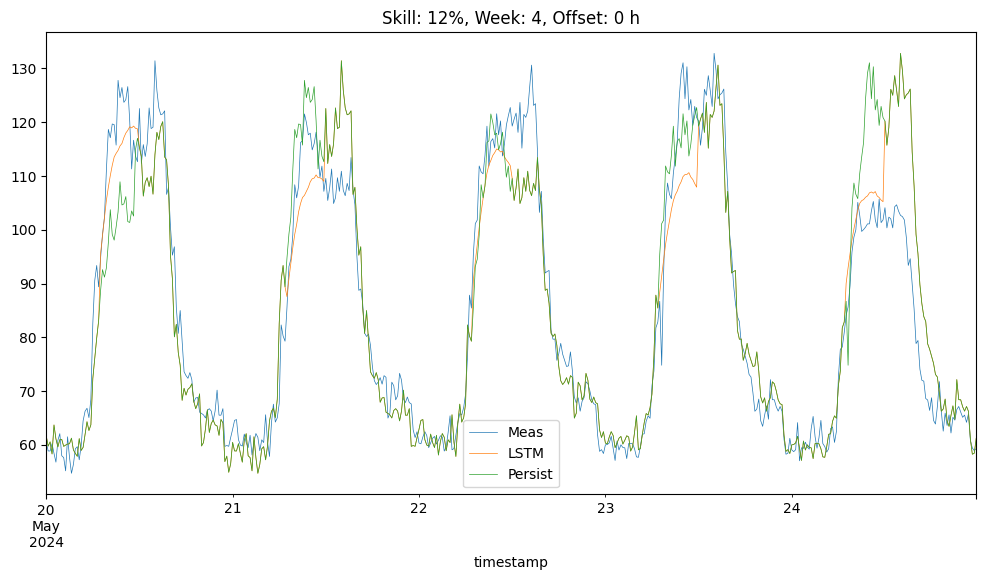

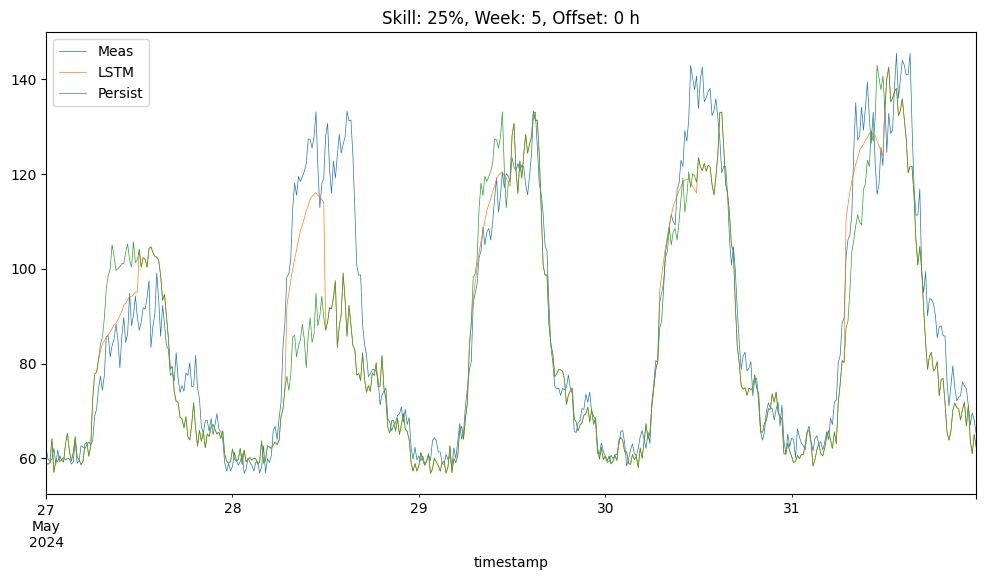

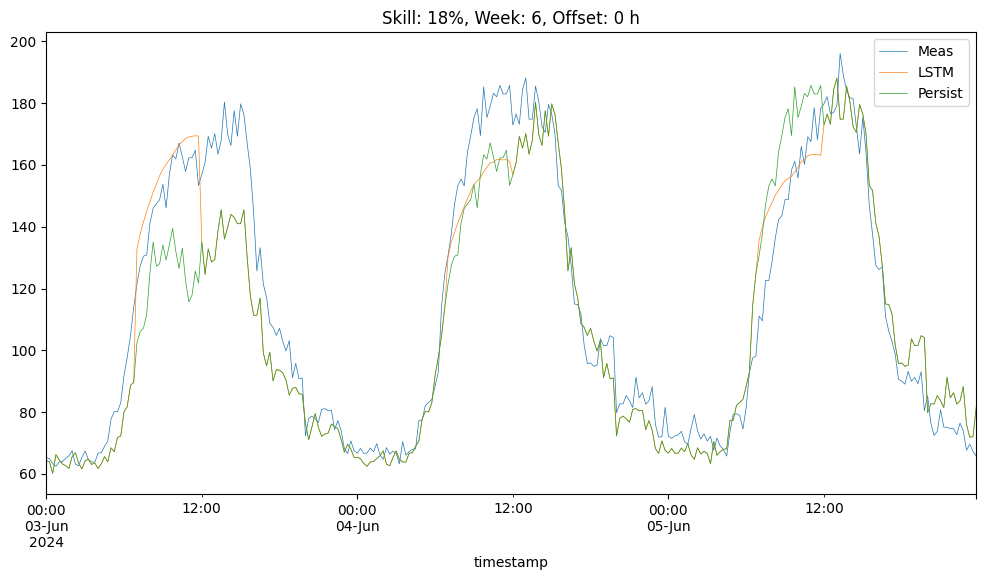

In [57]:
h_offset = 0

skills = []
daily_skills = []

for wk in range(7):
    t0 = df['timestamp_update'].iloc[0] + pd.Timedelta(f'{h_offset}h') + wk*pd.Timedelta(f'7d')

    yweek = pd.DataFrame([])

    for t in pd.date_range(t0,periods=5,freq='1d'):
        y = pd.DataFrame({'Meas':df[df.timestamp_update==t]['Load'].iloc[:(5*96)].values,
                          'LSTM':df[df.timestamp_update==t]['Pred'].iloc[:(5*96)].values,
                          'Persist':df[df.timestamp_update==t]['Persist'].iloc[:(5*96)].values},
                            index=df[df.timestamp_update==t]['timestamp'].iloc[:(5*96)])


        y.iloc[:8,1] = pd.NA #y.iloc[:8,2].values

        #y.LSTM = y.LSTM * (y.Persist.mean() / y.LSTM.mean()) # scale by mean of persistence

        #h_persist = 3
        #y.loc[t:t+pd.Timedelta(hours=h_persist),'LSTM'] = y.loc[t:t+pd.Timedelta(hours=h_persist),'Persist'].values # fill in first few values of persistence

        h_offpeak = list(range(7)) + list(range(12,24))
        y.loc[y.index.hour.isin(h_offpeak),'LSTM'] = y.loc[y.index.hour.isin(h_offpeak),'Persist'].values

        #new_dfplot = pd.DataFrame({ 'True':y_true.values,'LSTM':y_lstm.values,'Persist':y_pers.values},index=idx)
        yweek = pd.concat((yweek,y),axis=0)

        skill_mae = 1 - (y.Meas - y.LSTM).abs().mean() / (y.Meas - y.Persist).abs().mean()
        skill_mse = 1 - (y.Meas - y.LSTM).pow(2).mean() / (y.Meas - y.Persist).pow(2).mean()
        daily_skills.append(skill_mae)
        

    skill_mae = 1 - (yweek.Meas - yweek.LSTM).abs().mean() / (yweek.Meas - yweek.Persist).abs().mean()
    skill_mse = 1 - (yweek.Meas - yweek.LSTM).pow(2).mean() / (yweek.Meas - yweek.Persist).pow(2).mean()
    
    skills.append(skill_mae)

    yweek = yweek.interpolate()

    yweek.plot(title=f'Skill: {100*skill_mae:.0f}%, Week: {wk}, Offset: {h_offset} h',figsize=(12,6),linewidth=0.5)

skills = pd.Series(daily_skills)
print(f'Mean daily skill: {100*skills.mean():.0f}%')
print(f"Daily skills > 0: {100*skills[skills.values>0].count()/len(skills):.0f}%")
